In [1]:
import os
import math
import random
import argparse
from collections import Counter, defaultdict
from itertools import chain, combinations
import ast
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression


In [2]:
from Nash import find_nash_equilibria_v2

### HuG Dataset

In [ ]:
train_files_pattern = "metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = "metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set

In [5]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


In [6]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### Centrelized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[ 3069  2308     4    73  1531   148  5388]
 [ 1334  3722     5   224  1783   263  5425]
 [    0     0  7595     0     0     0     0]
 [   11    59   320  1165    46     0   335]
 [   69     8     6     4 22427    11  4145]
 [    2   119   369     0   394  1339   139]
 [ 1680  2170    10   157  6069   137 28238]]


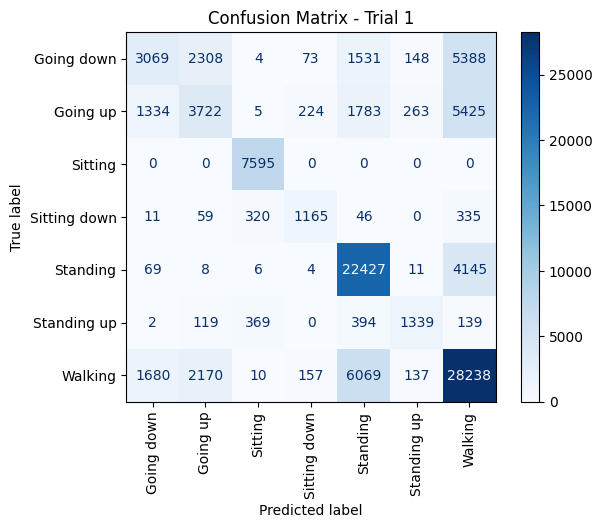

100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

Trial 1/1 - Global test accuracy: 0.6603552262441227


In [9]:
# Parameters
n_trials = 1
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

for trial in tqdm.tqdm(range(n_trials)):
    
    # Initialize Logistic Regression model
    model = LogisticRegression(random_state=42, max_iter=1000)  
    model.fit(X_train_global_scaled, y_train_global)  
    
    # Predict on the test set
    y_pred = model.predict(X_test_global_scaled)
    acc_test = accuracy_score(y_test_global, y_pred)  # Compute test accuracy
    
    # Confusion matrix
    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Trial {trial + 1}")
    plt.show()
    
    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")

#### FL

In [1]:
def aggregate_lr_models(models: list):

  aggregated_model = LogisticRegression(random_state=random_seed)
  aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
  aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
  aggregated_model.classes_ = models[0].classes_

  return aggregated_model


In [13]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42

results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")


    # Train models for the clients
    client_models = []
    client_global_accuracies = []
    for i in range(n_clients):
        # Load client-specific training data
        df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        # Train a Logistic Regression model for the client
        model = LogisticRegression(random_state=random_seed + trial, max_iter=1000)
        model.fit(scaler.fit_transform(X_train), y_train)  # Scale the data
        client_models.append(model)

        # Evaluate the model globally
        y_pred_global = model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations of models
    n_combinations = 2 ** n_clients
    for i in tqdm(range(1, n_combinations)):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate the models
        aggregated_model = aggregate_lr_models(included_models)

        # Evaluate the aggregated model globally
        y_pred_global = aggregated_model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

# Save results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv("HuG_results_with_LR.csv", index=False)


Trial 1/1


100%|██████████| 1023/1023 [00:06<00:00, 165.55it/s]


In [14]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(10)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
92,1,0001011101,"[1, 3, 4, 5, 7]",0.655780,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
220,1,0011011101,"[1, 3, 4, 5, 7, 8]",0.655253,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
204,1,0011001101,"[1, 3, 4, 7, 8]",0.654695,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
460,1,0111001101,"[1, 3, 4, 7, 8, 9]",0.654001,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
252,1,0011111101,"[1, 3, 4, 5, 6, 7, 8]",0.653943,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
124,1,0001111101,"[1, 3, 4, 5, 6, 7]",0.653698,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
212,1,0011010101,"[1, 3, 5, 7, 8]",0.653571,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
348,1,0101011101,"[1, 3, 4, 5, 7, 9]",0.653532,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
332,1,0101001101,"[1, 3, 4, 7, 9]",0.653180,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136
340,1,0101010101,"[1, 3, 5, 7, 9]",0.653171,0.462097,0.400768,0.600317,0.599623,0.611157,0.565195,0.603855,0.592467,0.574168,0.555136


In [15]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000011,1,"[1, 2]",0.471286
1,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.645829


In [17]:
from Functions import compute_and_visualize_shapley_values

      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.603855                  0.122054
4   Client 5        0.611157                  0.121466
2   Client 3        0.600317                  0.114309
3   Client 4        0.599623                  0.114009
7   Client 8        0.592467                  0.111752
8   Client 9        0.574168                  0.111305
9  Client 10        0.555136                  0.103522
5   Client 6        0.565195                  0.102073
0   Client 1        0.462097                  0.073259
1   Client 2        0.400768                  0.026250


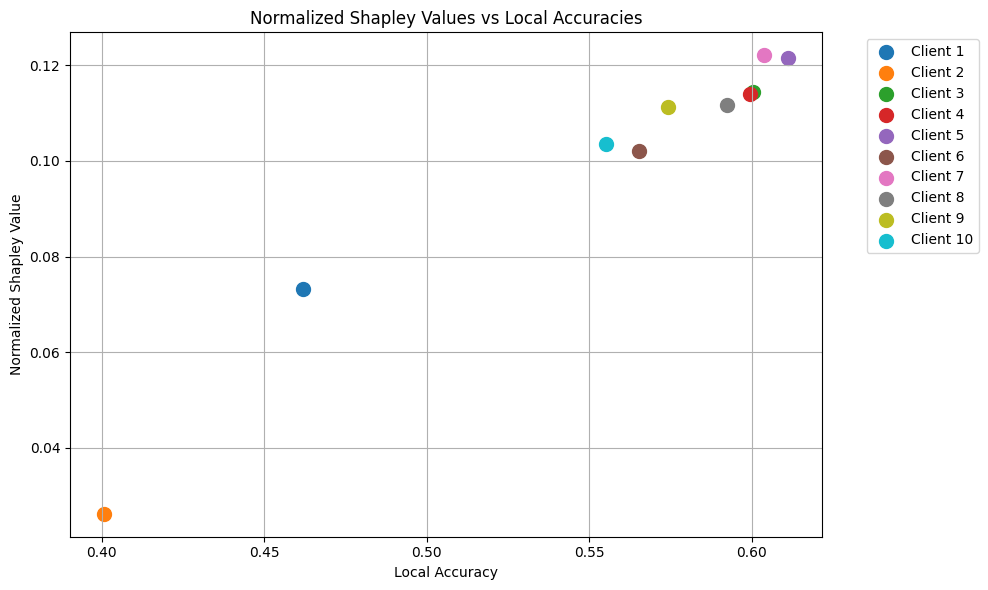

In [ ]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_global_accuracies,
    n_clients=10
)

### SpamBase Dataset

In [24]:
file_path = '.../spambase/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Preprocessing

In [25]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.9197


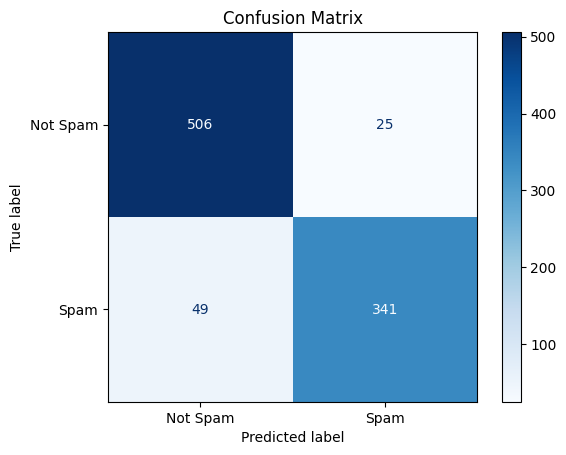

In [28]:
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  
model.fit(X_train, y_train)

# Evaluate the model
acc = model.score(X_test, y_test)  
print(f"Accuracy: {acc:.4f}")


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

### Fl

In [29]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False):

  if shuffle:
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]

  n_entries_per_client = X.shape[0] // n_clients
  partitions = []
  for i in range(n_clients):
    start = i*n_entries_per_client
    end = (i+1)*n_entries_per_client
    X_i = X[start:end]
    y_i = y[start:end]
    partitions.append((X_i, y_i))
  partitions[-1] = (X[start:], y[start:])

  return partitions

In [36]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [40]:
def train_client_models(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    client_local_accuracies = []

    for X_i, y_i in partitions:
        # Remove rows with NaN values
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_i_clean = X_i[nan_mask]
        y_i_clean = y_i[nan_mask]

        if len(y_i_clean) == 0:
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
            continue

        # Train Logistic Regression
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            model.fit(X_i_clean, y_i_clean)
            client_models.append(model)

            # Compute local accuracy on client data
            acc_local = model.score(X_i_clean, y_i_clean)
            client_local_accuracies.append(acc_local)

            # Compute accuracy on the global test set
            local_acc = model.score(X_test, y_test)
            client_global_accuracies.append(local_acc)

        except Exception as e:
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)

    return client_models, client_local_accuracies, client_global_accuracies


def run_federated_learning(
    partitions,
    n_clients=10,
    random_seed=None,
    max_iter=1000,
):

    partitions_copy = copy.deepcopy(partitions)

    # Train models for each client and compute accuracies
    client_models, client_local_accuracies, client_global_accuracies = train_client_models(
        partitions_copy, random_seed, X_test, y_test, max_iter
    )

    # Generate all possible combinations of clients represented as binary strings
    results = []
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        # Determine which clients are included in this combination
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices if client_models[j] is not None]

        if not included_models:
            # Skip combinations where no valid models are available
            continue

        # Aggregate models
        federated_model = aggregate_lr_models(included_models)
        agg_acc = federated_model.score(X_test, y_test)

        # Prepare the row data
        row = {'Combination': bin_str, 'Clients': [client + 1 for client in client_indices], 'Global Accuracy': agg_acc}

        # Add global accuracies for each client
        for j in range(n_clients):
            acc = client_global_accuracies[j] if client_global_accuracies[j] is not None else np.nan
            row[f"Client {j + 1} Accuracy"] = acc

        results.append(row)

    # Save results to CSV
    df_results = pd.DataFrame(results)
    file_name = "spambase_federated_logestic_reg_results.csv"
    df_results.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    return df_results, client_local_accuracies, client_global_accuracies


In [47]:
# Unpack the returned tuple
df_results, client_local_accuracies, client_global_accuracies = run_federated_learning(
    partitions, n_clients=10, random_seed=42, max_iter=1000
)

Results saved to spambase_federated_linear_logestic_results.csv


In [49]:
top_results = df_results.sort_values(by=['Global Accuracy'], ascending=False).head(10)
top_results

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
980,1111010101,"[1, 3, 5, 7, 8, 9, 10]",0.939197,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
660,1010010101,"[1, 3, 5, 8, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
884,1101110101,"[1, 3, 5, 6, 7, 9, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
788,1100010101,"[1, 3, 5, 9, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
916,1110010101,"[1, 3, 5, 8, 9, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
852,1101010101,"[1, 3, 5, 7, 9, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
988,1111011101,"[1, 3, 4, 5, 7, 8, 9, 10]",0.938111,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
404,0110010101,"[1, 3, 5, 8, 9]",0.937025,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
540,1000011101,"[1, 3, 4, 5, 10]",0.937025,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709
918,1110010111,"[1, 2, 3, 5, 8, 9, 10]",0.937025,0.909881,0.890337,0.884908,0.890337,0.909881,0.917481,0.889251,0.903366,0.897937,0.907709


In [50]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.932682


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.909881                  0.107273
5   Client 6        0.917481                  0.103941
0   Client 1        0.909881                  0.102582
9  Client 10        0.907709                  0.102470
7   Client 8        0.903366                  0.100168
8   Client 9        0.897937                  0.098469
2   Client 3        0.884908                  0.098320
3   Client 4        0.890337                  0.096303
1   Client 2        0.890337                  0.095733
6   Client 7        0.889251                  0.094741


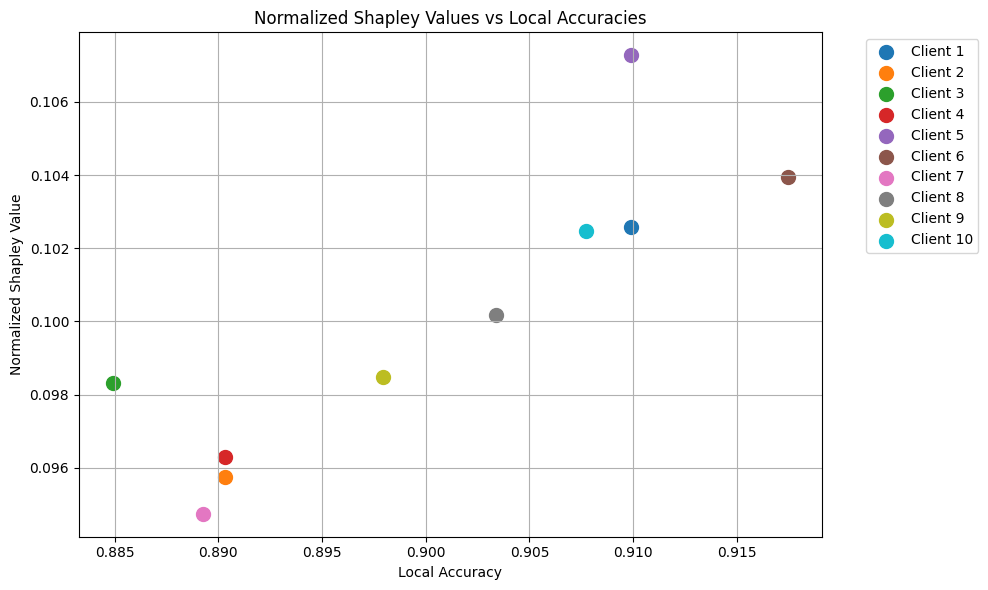

In [51]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_global_accuracies,
    n_clients=10)